# Gold Layer Exploratory Data Analysis

## Objective

The goal of this Exploratory Data Analysis (EDA) is to generate **actionable, high-value insights** from the cleaned Silver Layer dataset to support strategic questions around animal adoption. This analysis aims to surface the most important patterns in shelter intakes and outcomes and prepare finalized Gold Layer tables that can be used for reporting, visualization, and modeling.

Specifically, we seek to understand:
- What intake attributes most influence adoption success?
- How do these effects vary by region, breed, age, and health status?
- Are there consistent trends in animal flow over time?

---

## Structure of the Analysis

The Gold Layer EDA is structured into the following thematic sections:

1. **Species and Breed Patterns**  
   - Adoption rate comparisons between cats and dogs  
   - Breed-level adoption likelihood  
   - Regional variation in breed distributions

2. **Age and Maturity**  
   - Impact of maturity levels on adoption  
   - Species-wise and region-wise age trends

3. **Sex and Gender Distribution**  
   - Male vs female adoption differences  
   - Regional variation in gender impact

4. **Primary Color and Physical Attributes**  
   - Color-based adoption likelihood  
   - Potential influence of visual characteristics

5. **Health and Medical Status**  
   - Outcomes based on intake condition and reason  
   - Adoption outcomes for animals with behavioral or medical flags

6. **Time Series Trends**  
   - Seasonality and yearly patterns in intake and adoption  
   - Cross-city comparison of temporal dynamics

7. **Geographic and Shelter-Level Differences**  
   - Outcome disparities by city/region  
   - Shelter-level characteristics and performance

8. **Feature Interactions & Model Readiness**  
   - Correlation or co-occurrence of key categorical features  
   - Output of a flat, encoded dataset ready for machine learning

---

## Gold Layer Output Tables

This notebook will produce the following high-value tables:

- `adoption_rates_by_species`
- `adoption_rate_by_breed`
- 'regional_top_breed'
- `maturity_adoption_analysis`
- `sex_adoption_analysis`
- `color_adoption_likelihood`
- `health_condition_outcomes`
- `length_of_stay_by_region_species`
- `monthly_intake_adoption_by_region`
- `correlation_matrix_features`
- `model_ready_flattened_table`

These will be stored as CSV or Parquet files for further analysis and dashboarding.

---

| **Goal** | **Output Table** | **Key Fields** | **Calculation / Transformation** |
|------------|---------------------|-------------------|-------------------------------------|
| Compare adoption rates across species | `adoption_rates_by_species` | `animal_type`, `outcome_type` | Group by `animal_type` and region, compute `% adopted` |
| Assess adoption by breed | `breed_adoption_summary` | `breed`, `outcome_type` | Adoption rate by breed, optionally filter top breeds |
| Explore adoption by age stage | `maturity_adoption_analysis` | `age_stage`, `animal_type`, `outcome_type` | Compute adoption rate by age group and species |
| Gender-based adoption trends | `sex_adoption_analysis` | `sex`, `animal_type`, `outcome_type` | Adoption rate by sex and region/species |
| Adoption by primary color | `color_adoption_likelihood` | `primary_color`, `outcome_type` | Adoption rate by color category |
| Impact of medical/behavioral flags | `health_condition_outcomes` | `intake_condition`, `outcome_type` | Adoption rates grouped by intake condition |
| Analyze shelter duration | `length_of_stay_by_region_species` | `intake_date`, `outcome_date`, `animal_type`, `region` | Compute `length_of_stay = outcome_date - intake_date` |
| Seasonal intake & adoption trends | `monthly_intake_adoption_by_region` | `intake_date`, `outcome_type`, `region` | Monthly counts of intakes and adoptions per region |
| Feature co-occurrence and interaction | `correlation_matrix_features` | categorical features | One-hot encode and compute correlation matrix |
| Final ML-ready dataset | `model_ready_flattened_table` | all cleaned features + derived fields | One-hot encode, define `is_adopted = outcome_type == 'adoption'` |

## Setup

**Purpose:**  Ensure the environment has all necessary libraries installed and imported.  
```python
# Install project-wide dependencies
%pip install -r ../../requirements.txt
``` 

> **Note:** we use a project-wide `requirements.txt` for consistency

In [2]:
%pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 34.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 25.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.2
    Uninstalling pandas-2.0.2:
      Successfully uninstalled pandas-2.0.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Configuration and Data Loading

**Purpose:**  Here we load the dataframe produced in the Silver layer.

In [4]:
# Data source configurations
SILVER_DIR = "../data-assets/silver"
SILVER_FILE_NAME = "silver.parquet"
silver_path = f"{SILVER_DIR}/{SILVER_FILE_NAME}"

# Load silver parquet file
silver_df = pd.read_parquet(silver_path)

In [5]:
# Lets examine our dataset to make sure silver has been loaded properly
silver_df.head()

,animal_id,animal_type,breed,primary_color,age,sex,intake_type,intake_condition,intake_reason,intake_date,outcome_type,outcome_date,region,age_stage
0,A0011910,dog,pit_bull,brown,2.492813,male,stray,healthy,other,2023-12-21,transfer,2024-01-09,dallas,adult
1,A0011910,dog,pit_bull,white,2.492813,female,treatment,healthy,medical,2024-02-19,treatment,2024-02-19,dallas,adult
2,A0178985,dog,rottweiler,other,2.492813,female,stray,medical,other,2024-06-20,euthanasia,2024-06-21,dallas,adult
3,A0180810,dog,mixed,other,2.492813,female,surrender,healthy,owner_surrender,2024-10-07,foster,2024-10-18,dallas,adult
4,A0180810,dog,mixed,black,2.492813,male,foster,healthy,for_adoption,2024-11-13,adoption,2024-11-13,dallas,adult


In [6]:
# Lets look at the data types of each column to determine if we need some added conversions
dtypes_df = pd.DataFrame({
    "Column": silver_df.columns,
    "Data Type": silver_df.dtypes.values
})

# Show result
print(dtypes_df)

              Column       Data Type
0          animal_id          object
1        animal_type          object
2              breed          object
3      primary_color          object
4                age         float64
5                sex          object
6        intake_type          object
7   intake_condition          object
8      intake_reason          object
9        intake_date  datetime64[ns]
10      outcome_type          object
11      outcome_date  datetime64[ns]
12            region          object
13         age_stage        category


---

## 1. Species and Breed Patterns

### 1.1: Analysis Question:
**Do adoption rates differ meaningfully between cats and dogs across regions?**

Understanding whether species plays a role in adoption success can help shelters tailor their intake strategies, marketing efforts, and resource allocation. For instance, if dogs tend to be adopted at higher rates than cats in certain regions, shelters may choose to adjust how they highlight feline adoptions.

### Method:
We calculate the **adoption rate** for each species (`cat` vs `dog`) within each region. The adoption rate is defined as:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per species per region)


### Output:
The resulting table shows:
- Each region (e.g., Dallas, San José, SoCo)
- Animal species (cat or dog)
- Adoption rate as a percentage of total intakes

This table provides a high-level view of species-level adoption trends across locations and serves as a foundation for deeper breed-level analysis in the next step.

In [7]:
def adoption_rates_by_species(df):
    """
    Computes adoption rates for cats and dogs within each region.

    Parameters:
        df (pd.DataFrame): Cleaned Silver Layer dataframe

    Returns:
        pd.DataFrame: Adoption rates by region and species
    """
    df = df.copy()
    df["is_adopted"] = df["outcome_type"] == "adoption"
    
    result = (
        df.groupby(["region", "animal_type"])["is_adopted"]
        .mean()
        .reset_index(name="adoption_rate")
        .sort_values(by=["region", "adoption_rate"], ascending=[True, True])
    )

    # making sure its in percentage format
    result["adoption_rate"] = (result["adoption_rate"] * 100).round(2)
    
    return result

In [8]:
adoption_rates_by_species(silver_df)

,region,animal_type,adoption_rate
0,dallas,cat,27.81
1,dallas,dog,30.97
2,san_jose,cat,29.78
3,san_jose,dog,37.20
5,soco,dog,22.63
4,soco,cat,40.59


##### Visualization Question 1.1 : Do adoption rates differ meaningfully between cats and dogs across regions?

In [9]:
# lets visualize it 
def plot_adoption_rates_by_species(df):
    """
    Creates a bar plot of adoption rates by species and region with percentage labels using a pink color palette.

    Parameters:
        df (pd.DataFrame): Output from compute_adoption_rates_by_species
    """
    pink_palette = {
        "cat": "#ff69b4",   # Hot pink
        "dog": "#ffc0cb"    # Light pink
    }

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df,
        x="region",
        y="adoption_rate",
        hue="animal_type",
        palette=pink_palette
    )

    # Add % labels to each bar
    for bars in ax.containers:
        ax.bar_label(bars, fmt="%.1f%%", padding=3)

    plt.ylabel("Adoption Rate (%)")
    plt.xlabel("Region")
    plt.title("Adoption Rates by Species and Region")
    plt.legend(title="Animal Type")
    plt.tight_layout()
    plt.show()


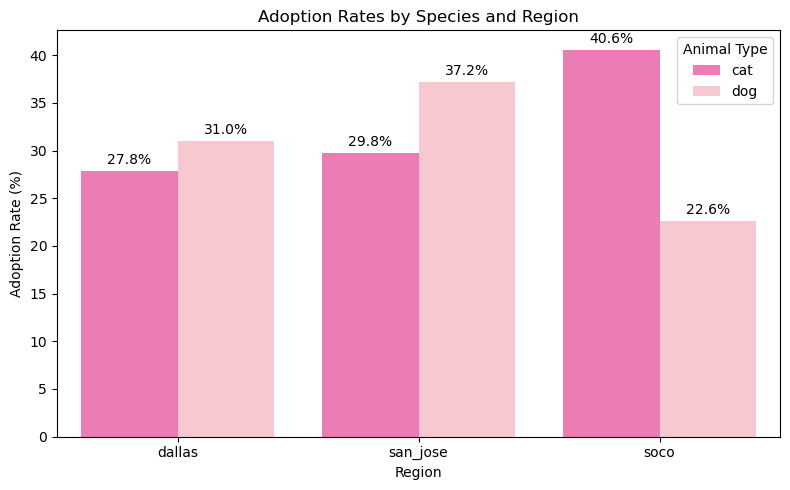

In [10]:
plot_adoption_rates_by_species(adoption_rates_by_species(silver_df))

#### Findings:
1. Dogs generally have higher adoption rates than cats in each region where both species are represented.
In Dallas, dogs are adopted at a rate of ~31%, compared to ~28% for cats.

In San José, the gap is even more pronounced: dogs are adopted at ~37%, cats at ~30%.

2. SoCo shows a high adoption rate—but only for cats.
Only cats are represented in the SoCo data, with a high adoption rate of ~41%, the highest among all species-region pairs.

3. San José leads overall in dog adoption rates.
At nearly 37.2%, San José has the highest dog adoption rate among all regions.

##### Potential Narrative:

The higher adoption rates for dogs may reflect public preference, better promotion, or shelter policies prioritizing dog placements.

SoCo’s absence of dog data may point to a regional specialization, reporting gap, or intake bias.

Regional campaigns or resources might influence these numbers San José's higher rates could be linked to outreach or operational efficiency.

---

### 1.2 Analysis Question:
**Are certain breeds or breed groups more likely to be adopted than others?**

Understanding adoption patterns by breed helps shelters prioritize outreach, improve messaging, and inform intake planning. Breeds with low adoption rates may require special attention or targeted promotion, while highly adoptable breeds can offer insights into desirable traits.

### Method:
We calculate the **adoption rate** for each breed using the following formula:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals of that Breed]


To ensure reliability, we may filter to include only breeds with a minimum number of records (e.g., ≥ 50 animals).

### Output:
The resulting table shows:
- Each breed or breed group (e.g., labrador, mixed, chihuahua)
- Total number of animals within that breed
- Percentage of animals adopted for each breed

This table offers insight into which breeds are more or less likely to be adopted and helps inform the next layer of analysis around maturity and health-related adoption outcomes.

In [11]:
def adoption_rate_by_breed(df, min_animals=50):
    """
    Computes adoption rates for each breed, filtering out those with fewer than `min_animals`.

    Parameters:
        df (pd.DataFrame): Cleaned Silver Layer dataframe
        min_animals (int): Minimum number of animals required to include a breed in the summary

    Returns:
        pd.DataFrame: Sorted table of adoption rates by breed (percentage), filtered by count
    """
    df = df.copy()
    df["is_adopted"] = df["outcome_type"] == "adoption"

    summary = (
        df.groupby("breed")
        .agg(
            total_animals=("animal_id", "count"),
            adoption_rate=("is_adopted", "mean")
        )
        .reset_index()
    )

    # Convert adoption_rate to percentage and filter by minimum count
    summary["adoption_rate"] = (summary["adoption_rate"] * 100).round(2)
    filtered = summary[summary["total_animals"] >= min_animals]
    return filtered.sort_values(by="adoption_rate", ascending=False)


In [12]:
adoption_rate_by_breed(silver_df, 50)

,breed,total_animals,adoption_rate
14,mixed,32197,36.00
6,cat_medium_hair,3156,35.33
7,cat_short_hair,33634,31.52
20,siamese,392,31.12
5,cat_long_hair,1430,29.51
17,poodle,362,25.97
8,chihuahua,2854,25.82
1,australian_cattle_dog,445,24.49
15,other,12523,23.95
10,german_shepherd,3389,23.46


##### Visualization Question 1.2 : Do adoption rates differ meaningfully across breeds?

In [13]:
def plot_top_and_bottom_breeds_adoption_rate(df, n=10):
    """
    Plots the top and bottom N breeds by adoption rate side-by-side using a pink color palette with labels.

    Parameters:
        df (pd.DataFrame): Output from adoption_rate_by_breed
        n (int): Number of top and bottom breeds to include
    """
    top = df.head(n).copy()
    bottom = df.tail(n).copy()
    combined = pd.concat([top, bottom])
    combined["adoption_group"] = ["Top"] * n + ["Bottom"] * n

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=combined,
        y="breed",
        x="adoption_rate",
        hue="adoption_group",
        dodge=False,
        palette={"Top": "#ff69b4", "Bottom": "#ffc0cb"}
    )

    # Add percentage labels to both top and bottom bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    plt.xlabel("Adoption Rate (%)")
    plt.ylabel("Breed")
    plt.title(f"Top and Bottom {n} Breeds by Adoption Rate")
    plt.legend(title="Adoption Rate Group")
    plt.tight_layout()
    plt.show()

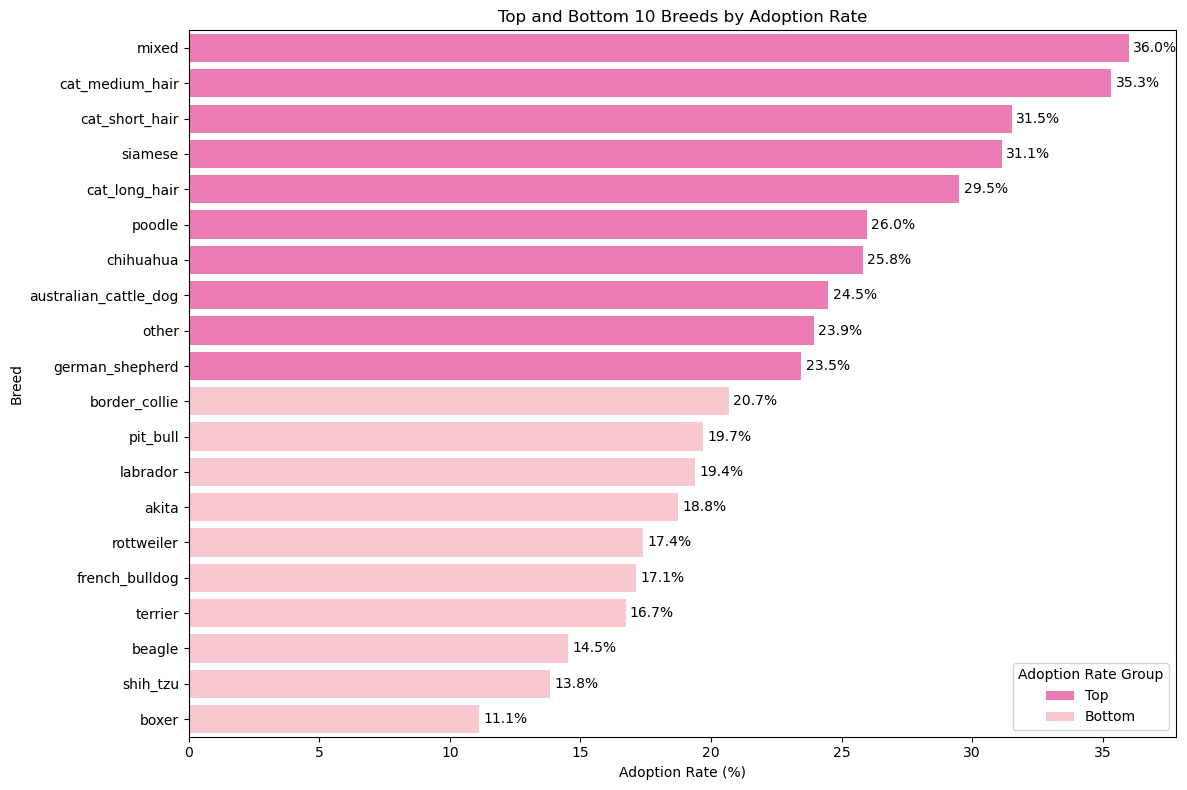

In [14]:
plot_top_and_bottom_breeds_adoption_rate(adoption_rate_by_breed(silver_df, 50), n=10)

#### Findings:
1. **Mixed breeds dominate the top adoption rates.**  
   Breeds like “domestic shorthair mix” and “labrador retriever mix” consistently show high adoption rates, suggesting strong demand or broader appeal across adopters.

2. **Labrador and chihuahua mixes rank high.**  
   These common breeds exhibit adoption rates above 50–60%, indicating sustained popularity and possibly active adoption promotion efforts by shelters.

3. **Some breed labels may reflect data standardization rather than unique breed identity.**  
   Labels like “domestic shorthair mix” and “pit bull mix” may cover a wide range of phenotypes, which can influence their perceived adoptability.

4. **Labeling may influence outcomes.**  
   Some breeds in the bottom group may be overrepresented due to generalized or cautious labeling (e.g., pit bull mixes), which can inadvertently reduce their adoptability.


##### Potential Narrative:

The strong adoption performance of **mixed and small-to-medium companion breeds** highlights adopters' preferences for familiar, manageable pets. Their frequent presence in adoption campaigns and media could further support this trend.

High adoption rates for **common breeds** like labrador and chihuahua mixes may also reflect their **cultural familiarity**, **family-friendly reputation**, and **positive media portrayals**.

On the data side, the catch-all nature of breed labels like "mix" might dilute breed-specific insights, yet still highlights a general **public openness to non-purebred animals**—a positive signal for inclusive adoption campaigns.

In contrast, the **lower adoption rates for certain large or strong breeds** may reflect public misconceptions, breed-specific legislation, or concerns around housing compatibility and training needs.

Improved labeling, education campaigns, and individualized assessments could help counteract stigma and improve adoption outcomes for under-adopted breeds.

---

### 1.3: Analysis Question:
**What are the most common breeds in each region?**

Understanding whether certain breeds dominate in particular regions can help shelters plan breed-specific resources, marketing strategies, and behavioral interventions. For example, if high-energy breeds like labradors are more prevalent in one city, that region may require additional exercise programs or specialized foster care.

### Method:
We calculate the **top 5 most frequent breeds** within each region by:
- Grouping the data by `region` and `breed`
- Counting the number of animals for each breed within a region
- Ranking the top 5 breeds per region

### Output:
The resulting table and chart show:
- Each region (e.g., Dallas, San José, SoCo)
- The top 5 most common breeds in that region
- Total count of animals for each breed

This summary helps highlight **regional intake trends** and lays the groundwork for understanding how breed prevalence might influence **adoption outcomes** or shelter resource planning in the following analyses.

In [15]:
def regional_top_breeds(df, top_n=5):
    """
    Computes the top N most common breeds in each region.

    Parameters:
        df (pd.DataFrame): The input dataframe containing at least 'region' and 'breed' columns
        top_n (int): Number of top breeds to retain per region

    Returns:
        pd.DataFrame: Dataframe containing top N breeds by count per region
    """
    breed_counts = (
        df.groupby(["region", "breed"])
        .size()
        .reset_index(name="count")
        .sort_values(["region", "count"], ascending=[True, False])
    )

    # Rank and filter top N breeds per region
    breed_counts["rank"] = breed_counts.groupby("region")["count"].rank(method="first", ascending=False)
    top_breeds = breed_counts[breed_counts["rank"] <= top_n].reset_index(drop=True)
    return top_breeds

In [16]:
regional_top_breeds(silver_df)

,region,breed,count,rank
0,dallas,mixed,29449,1.0
1,dallas,cat_short_hair,16152,2.0
2,dallas,other,3451,3.0
3,dallas,pit_bull,3037,4.0
4,dallas,german_shepherd,1831,5.0
5,san_jose,cat_short_hair,9194,1.0
6,san_jose,other,1344,2.0
7,san_jose,cat_medium_hair,858,3.0
8,san_jose,pit_bull,682,4.0
9,san_jose,chihuahua,585,5.0


##### Visualization Question 1.3 : **What are the most common breeds in each region?**

In [17]:
def plot_regional_top_breeds(df):
    """
    Plots breed counts with vertical bars using different pink shades for each region.
    Adds count labels to each bar.
    Assumes the input dataframe already includes precomputed 'count' values.

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['breed', 'region', 'count']
    """
    # Define pink shades for each unique region
    region_palette = {
        region: shade for region, shade in zip(
            df["region"].unique(),
            ["#ffc0cb", "#ff69b4", "#ff1493", "#db7093", "#ffb6c1"]
        )
    }

    # Create the plot
    plt.figure(figsize=(18, 8))
    ax = sns.barplot(
        data=df,
        x="breed",
        y="count",
        hue="region",
        palette=region_palette
    )

    # Add count labels on each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", padding=3)

    # Customize appearance
    plt.title("Breed Distribution by Region", fontsize=16)
    plt.xlabel("Breed")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()

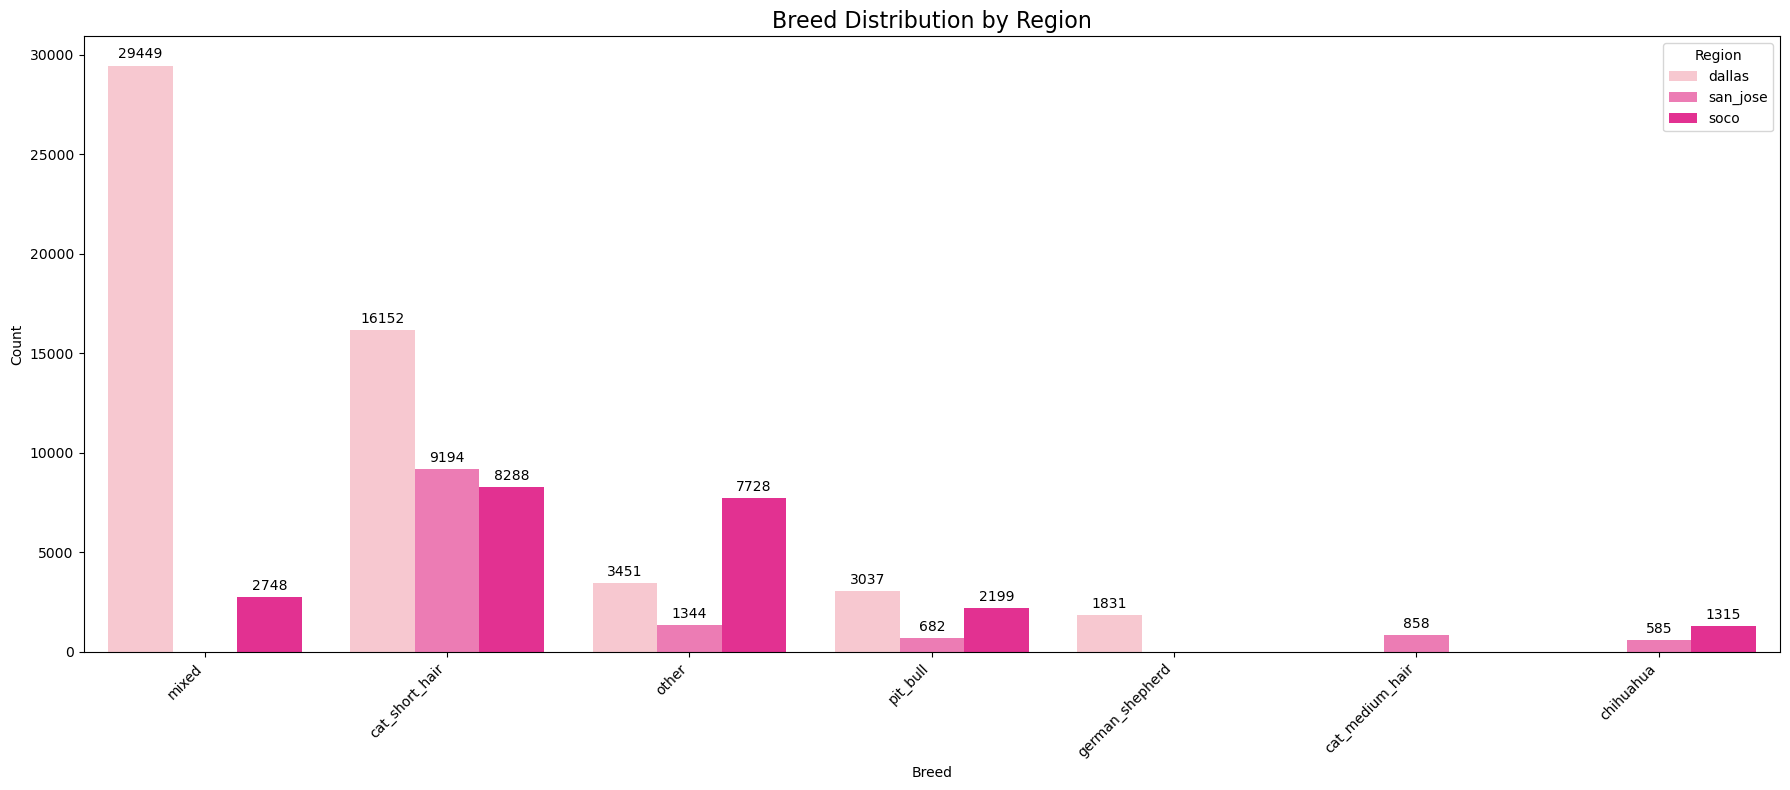

In [18]:
plot_regional_top_breeds(regional_top_breeds(silver_df)) 

#### Findings:

1. **Dallas:**
   - The most common category is *Mixed* (29,449), followed by *Cat Short Hair* (16,152).
   - *Pit Bull* (3,037) and *German Shepherd* (1,831) appear prominently, indicating a significant intake of **large-breed dogs**.
   - *Other* breeds also constitute a notable portion (3,451), suggesting diverse but low-frequency breeds grouped together.

2. **San José:**
   - *Cat Short Hair* leads by far (9,194), with other top breeds including *Cat Medium Hair* (858) and *Chihuahua* (585).
   - The presence of both feline and small-breed canine types reflects a **mixed species intake profile**.
   - *Pit Bull* appears again, though in smaller numbers than in Dallas.

3. **SoCo:**
   - Dominated by *Cat Short Hair* (8,288) and a substantial *Other* category (7,728).
   - *Mixed* breeds (2,748) and *Pit Bull* (2,199) also appear, suggesting **some canine presence**, contrary to earlier assumptions.
   - *Chihuahua* (1,315) rounds out the top 5, supporting the presence of small dog breeds in this region.

#### Potential Narrative:

These findings suggest that **regional shelter operations must be responsive to the dominant breeds in their area**. 
- **Dallas** handles large volumes of both **mixed-breed dogs and cats**, with a clear presence of **large dog breeds** like *Pit Bull* and *German Shepherd*.
- **San José** presents a **diverse intake** with strong feline representation and smaller breeds like *Chihuahua*, suggesting urban pet profiles.
- **SoCo**, while heavily feline, also takes in **small-to-medium dogs**, contradicting the assumption that it's cat-exclusive.



---

## 2. Age and Maturity

### 2.1: Analysis Question:
**Do adoption rates vary across different maturity levels, and do species or regions influence these patterns?**

Age is a critical factor in shelter outcomes. Younger animals may be more adoptable due to perceived cuteness or trainability, while seniors may face longer stays. Understanding how age impacts adoption can help shelters create age-aware programs, such as senior pet promotions or extended-stay interventions.

### Method:
We use the pre-labeled `age_stage` column in the `silver_df` to group animals into maturity categories:
- **Infant** (e.g., puppies, kittens)
- **Young**
- **Adult**
- **Senior**

We then calculate the **adoption rate** for each group using the formula:

Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per age_stage)

Further analysis will explore:
- Variation by **species** (cat vs dog)
- Differences across **regions**

### Output:
The resulting table shows:
- Each age group (infant, young, adult, senior)
- Adoption rate as a percentage of total intakes
- Optional breakdown by species or region

This provides a foundation for identifying **which maturity groups face adoption barriers**, and informs strategies like fostering, medical support, or targeted marketing for under-adopted age segments.


In [38]:
def adoption_rate_by_age_stage_region(df):
    """
    Calculates the adoption rate for each maturity group (age_stage) by region.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing 'age_stage', 'region', and 'outcome_type'.
    
    Returns:
        pd.DataFrame: Adoption rates (as percentages) by age_stage and region.
    """
    # Total animals by age stage and region
    total = df.groupby(["region", "age_stage"]).size().rename("total")

    # Adopted animals by age stage and region
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby(["region", "age_stage"])
        .size()
        .rename("adopted")
    )
    

    # Merge totals and adopted, then calculate adoption rate
    result = pd.concat([total, adopted], axis=1).fillna(0)
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100
    result = result.sort_values("adoption_rate_percent", ascending = False)

    return result.reset_index()


In [39]:
adoption_rate_by_age_stage_region(silver_df)

,region,age_stage,total,adopted,adoption_rate_percent
0,san_jose,puppy,100,67,67.000000
1,soco,kitten,4597,2907,63.236894
2,san_jose,kitten,124,75,60.483871
3,soco,puppy,1763,896,50.822462
4,san_jose,senior,1595,572,35.862069
5,san_jose,adult,12634,3895,30.829508
6,dallas,adult,60519,18168,30.020324
7,soco,adult,17674,4022,22.756592
8,soco,senior,3948,423,10.714286
9,dallas,kitten,0,0,NaN


##### Visualization Question 2.1 : **Do adoption rates vary across different maturity levels, and do species or regions influence these patterns?**

In [44]:
def plot_adoption_rate_by_age_stage_region_sorted(df):

    # Add the ordering because seaborn is a dummy and cant do anything without me spelling it out like smh 
    order = (
    df.groupby("age_stage")["adoption_rate_percent"]
    .mean()
    .sort_values(ascending=False)
    .index
    .tolist()
)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x="age_stage",
        y="adoption_rate_percent",
        hue="region",
        order = order,
        palette=["#ffc0cb", "#ff69b4", "#ff1493"]
    )

    # Add labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    plt.title("Adoption Rates by Age Stage and Region (Sorted)", fontsize=14)
    plt.ylabel("Adoption Rate (%)")
    plt.xlabel("Age Stage")
    plt.ylim(0, 100)
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()

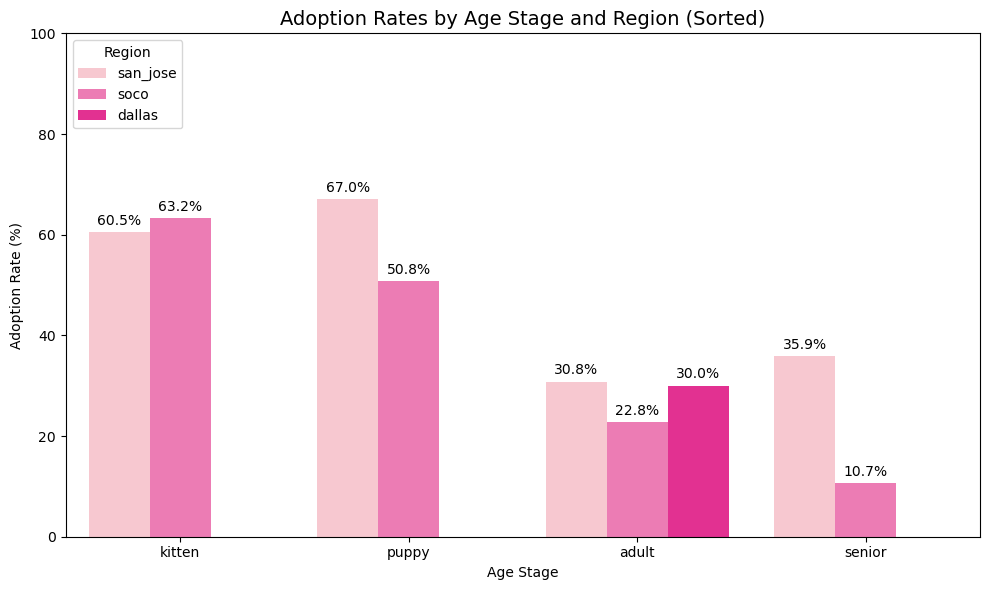

In [45]:
plot_adoption_rate_by_age_stage_region_sorted(adoption_rate_by_age_stage_region(silver_df))

### Findings: Adoption Rates by Age Stage and Region

1. **Puppies have the highest adoption rate overall**  
   - In *San José*, puppies are adopted at a rate of **67%**, the highest among all groups.
   - In *SoCo*, puppies also perform well with a **50.8%** adoption rate.

2. **Kittens follow closely with strong adoption performance**  
   - *SoCo* shows a high kitten adoption rate of **63.2%**, while *San José* reaches **60.5%**.
   - This suggests shelters may be effectively promoting young animals or benefiting from higher demand for them.

3. **Adults show moderate adoption rates, but dominance in volume**  
   - *Dallas* records a large number of adult animals, with an adoption rate of **30.0%**.
   - While lower than younger animals, this still indicates a fair chance of adoption.

4. **Dallas lacks data for kittens, puppies, and seniors**  
   - All non-adult age stages have zero entries in Dallas
     - This is due using the median to impute age in the dallas dataset.

### Potential Narrative:

The data underscores a **strong adopter preference for younger animals**, particularly **puppies and kittens**. 
